# Capstone Project

###### This notebook will be mainly used for the capstone project

### Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


!conda install -c conda-forge geopy

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


### Get Data

In [2]:
# New York
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
    
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


In [3]:
# Toronto
from bs4 import BeautifulSoup
toronto = BeautifulSoup(requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', timeout=5).content, 'html.parser')

columns=['Postcode', 'Borough', 'Neighbourhood']
post_table = toronto.find('table')
post_row = post_table.findAll('tr')
db_toronto = pd.DataFrame(columns=columns)

for idx, val in enumerate(post_row):
    post_cell = val.findAll('td')
    df = []
    for idx, val in enumerate(post_cell):
        df.append(val.text.rstrip())
    if(int(len(df)) > 0):
        if(df[1] != "Not assigned"):
            if(df[2] == "Not assigned"):
                df[2] = df[1]

            df_dic={columns[0]: df[0], columns[1]: df[1], columns[2]: df[2]}
            db_toronto = db_toronto.append(df_dic, ignore_index=True)

db_toronto = db_toronto.groupby('Postcode', as_index=False).agg(lambda x: ', '.join(set(x.dropna())))

!wget -O geo_data.csv https://cocl.us/Geospatial_data
db_geo = pd.read_csv("geo_data.csv")
db_toronto = db_toronto.join(db_geo)
db_toronto = db_toronto.drop(db_toronto.columns[3], axis=1)

--2020-02-17 05:51:43--  https://cocl.us/Geospatial_data
Resolving cocl.us (cocl.us)... 158.85.108.83, 169.48.113.194, 158.85.108.86
Connecting to cocl.us (cocl.us)|158.85.108.83|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-02-17 05:51:45--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 107.152.26.197, 107.152.27.197
Connecting to ibm.box.com (ibm.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-02-17 05:51:46--  https://ibm.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/9afzr83pps4pwf2sm

### Connect to FourSquare

In [4]:
# The code was removed by Watson Studio for sharing.

### Get Venues for both cities

In [5]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [6]:
# New York Venues
ny_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                  latitudes=neighborhoods['Latitude'],
                                  longitudes=neighborhoods['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [9]:
# Toronto Venues
db_toronto.rename(columns = {'Neighbourhood':'Neighborhood'}, inplace = True) 
tor_venues = getNearbyVenues(names=db_toronto['Neighborhood'],
                                  latitudes=db_toronto['Latitude'],
                                  longitudes=db_toronto['Longitude'])

Rouge, Malvern
Port Union, Highland Creek, Rouge Hill
Guildwood, West Hill, Morningside
Woburn
Cedarbrae
Scarborough Village
Ionview, East Birchmount Park, Kennedy Park
Oakridge, Clairlea, Golden Mile
Cliffside, Scarborough Village West, Cliffcrest
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Maryvale, Wexford
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Steeles East, Milliken, Agincourt North, L'Amoreaux East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Willowdale, Newtonbrook
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Downsview North, Bathurst Manor, Wilson Heights
York University, Northwood Park
Downsview East, CFB Toronto
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

### Compare Venues between Cities

In [99]:
ny_address = 'New York City, NY'

geolocator = Nominatim()
ny_location = geolocator.geocode(ny_address)
ny_latitude = ny_location.latitude
ny_longitude = ny_location.longitude
                                                                       
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='fuchsia',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_newyork)  
    
map_newyork

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


In [95]:

# New York Venues
ny_count = ny_venues['Venue Category'].value_counts()
tor_count = tor_venues['Venue Category'].value_counts()
ny_count = ny_count.sort_index(ascending=True)

df = pd.DataFrame(ny_count).transpose()

df.append(dict(zip(df.columns, [col[1] for col in df])), ignore_index=True)
df

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen R

In [96]:
# Tronto Venues
ny_count.rename({"Venue Category": "New York"}, axis='index')
tor_count = tor_count.sort_index(ascending=True)

df2 = pd.DataFrame(tor_count).transpose()

df2.append(dict(zip(df2.columns, [col[1] for col in df2])), ignore_index=True)
df2

,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Campground,Cantonese Restaurant,Caribbean Restaurant,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hostel,Hotel,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
Venue Category,3,4,1,25,1,1,6,9,32,16,2,1,27,13,109,35,1,2,16,15,4,1,3,4,25,2,4,5,43,39,2,1,19,56,24,7,125,3,4,40,2,1,1,39,1,9,1,8,16,10,175,1,1,2,2,5,1,7,2,13,1,8,2,2,3,5,20,2,2,28,20,4,1,6,2,1,1,8,2,8,4,5,13,2,15,5,4,1,10,9,2,7,4,10,3,3,2,16,11,5,1,27,2,10,37,2,10,2,3,3,27,9,25,52,39,26,5,2,7,1,3,7,5,2,7,1,2,41,2,3,40,47,4,4,98,56,2,5,1,6,4,29,1,9,47,3,1,1,3,14,4,23,58,1,1,15,6,1,5

Text(0.5, 1.0, 'Top 10 Venues in New York')

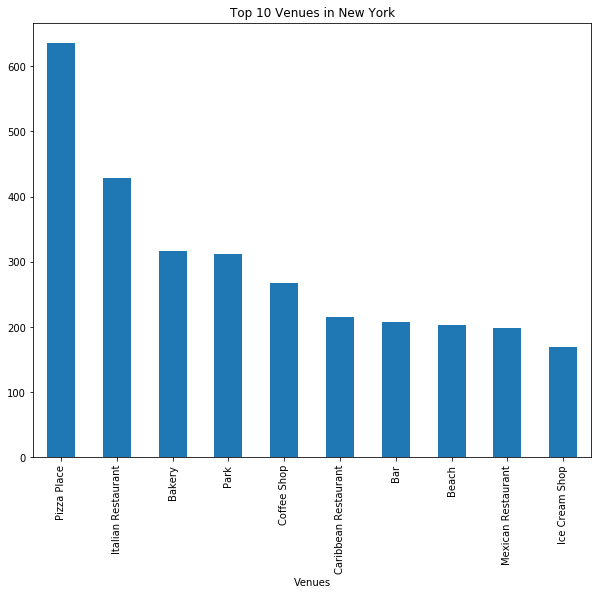

In [97]:
plt.figure(figsize=(10,8))
ny_venues['Venue Category'].value_counts().nlargest(10).plot(kind='bar')
plt.xlabel('Venues')
plt.title('Top 10 Venues in New York')

Text(0.5, 1.0, 'Top 10 Venues in Toronto')

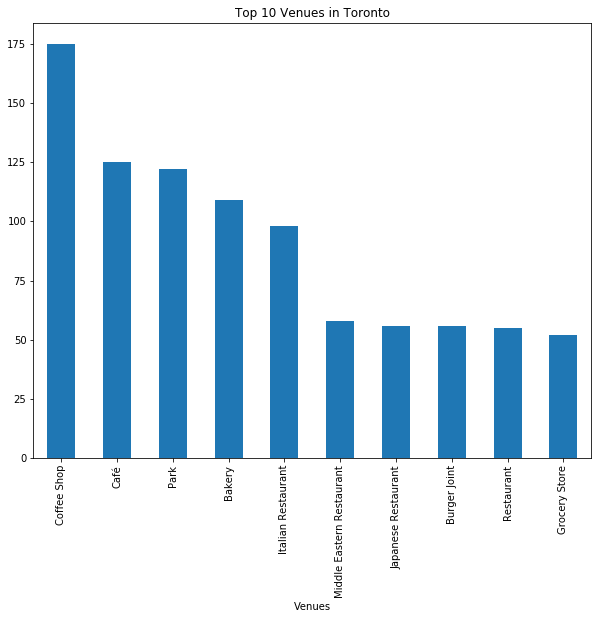

In [91]:
plt.figure(figsize=(10,8))
tor_venues['Venue Category'].value_counts().nlargest(10).plot(kind='bar')
plt.xlabel('Venues')
plt.title('Top 10 Venues in Toronto')